In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from os import listdir
from sklearn.model_selection import StratifiedShuffleSplit

from src.ml.util import get_feature_desc, get_tf_sample

In [23]:
iteration = 0

### Reading all samples

All samples are read from the `data` directory, to later on be split into a training and validation set. Each sample is the result of a self-played game, by splitting the dataset it is important to make sure they are balanced, in this case it means there is a representation of wins and losts scenarios. 

In [24]:
directory = f'robot_reboot_data/iter_{iteration}/'

In [25]:
filenames = [f'{directory}{i}' for i in listdir(directory)]
filenames

['robot_reboot_data/iter_0/robot_reboot_12.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1631.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1407.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1294.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1777.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1893.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1588.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_1541.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_2068.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_2542.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_707.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_2890.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_2859.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_531.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_2297.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_2774.tfrecords',
 'robot_reboot_data/iter_0/robot_reboot_641.tfrecords',
 'robot_reboot_data/iter_0/robot_reb

Following the data will be read from the `tfrecords` files and parsed into a data frame to explore the outputs of each game and the complete data (i.e it includes the state `s`, outcome `v` and probabilities `p`) is temporarily store in a list `parsed_data` for later used

In [26]:
actions_cols = [f'a_{i}' for i in range(0, 16)]
data_map = list()
parsed_data = list()
dataset = tf.data.TFRecordDataset(filenames)
for serialized in dataset:
    parsed = tf.io.parse_single_example(serialized, get_feature_desc())
    
    p = tf.sparse.to_dense(parsed['p']).numpy()
    v = parsed['v'].numpy()
    s = tf.sparse.to_dense(parsed['s']).numpy()
    parsed_data.append({
        'p': p,
        'v': v,
        's': s
    })
    obj = {
        'v': v,
    }

    for j in range(len(actions_cols)):
        col = actions_cols[j]
        p_j = p[j]
        obj[col] = p_j
    data_map.append(obj)

`data_df` depicts the outcome of each game in `v` (`1` for a win and `0` for a loss) and the probability of winning for each action. The state of the game is not needed for now. 

In [27]:
data_df = pd.DataFrame(data = data_map)
data_df.head()

,v,a_0,a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,a_12,a_13,a_14,a_15
0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.0,1.00,0.00,0.00,0.00,0.0,0.80,0.72,0.76,0.76,0.74,0.76,0.76,0.74,0.72,0.74,0.74
4,0.0,0.78,0.84,0.86,0.82,0.0,0.78,0.70,0.80,0.76,0.80,0.82,0.84,0.46,0.00,0.00,1.00


In [28]:
data_df.shape

(2999, 17)

Now, it's possible to explore how are the samples distrubed among wins and losses

In [29]:
outcomes_df = data_df.groupby('v').agg({'v': ['count']})['v']
outcomes_df

,count
v,
0.0,2886
1.0,113


<AxesSubplot:xlabel='v'>

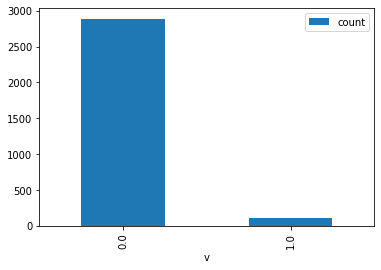

In [30]:
outcomes_df.plot(kind='bar')

The dataset is not balanced given that are more states representing losses than winning scenarios. It's important to split them using the stratified method to make sure wins and losses are both equally represented in each data set.

### Splitting data stratified
The data frame `data_df` does not contain all the data so `x` will be used to represent the index in the real data set and `y` will be represented by the `v` values in order to ensure they are splited equally among datasets.

In [31]:
x = pd.DataFrame(data=[i for i in range(data_df.shape[0])])
y = data_df.drop(columns=actions_cols)

In [32]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=26)

In [33]:
for train_index, val_index in sss.split(x, y):
    train = [parsed_data[i] for i in range(len(parsed_data)) if i in train_index]
    validation = [parsed_data[i] for i in range(len(parsed_data)) if i in val_index]
    

Next, it's posible to see how the data was distributed among training and validation datasets based on the games outputs. Both datasets contain an equal representation of losses and wins within. 

In [34]:
def get_data_frame_v(data):
    data_v = list()
    for d in data:
        v = d['v']
        data_v.append({'v': v})
    return pd.DataFrame(data = data_v)

In [35]:
train_df = get_data_frame_v(train)
validation_df = get_data_frame_v(validation)

In [36]:
train_df.groupby('v').agg({'v': ['count']})

,v
,count
v,
0.0,2020
1.0,79


In [37]:
validation_df.groupby('v').agg({'v': ['count']})

,v
,count
v,
0.0,866
1.0,34


Finally the complete data is saved into `tfrecords` files, one for training and one for validation.

In [39]:
def create_ds(channel, data):
    with tf.io.TFRecordWriter(f'{directory}{channel}.tfrecords') as f:
        for d in data:
            sample = get_tf_sample(d['v'], d['p'], d['s'])
            f.write(sample.SerializeToString())

In [40]:
create_ds('train', train)
create_ds('validation', validation)